# 네이버 매장정보 크롤링

#### 자료 
https://www.localdata.go.kr/devcenter/dataDown.do?menuNo=20001

1. 관광식당, 일반음식점, 휴게음식점 데이터셋 다운로드(07_24_01_P_.csv.zip, 07_24_04_P_.csv.zip , 07_24_05_P_.csv.zip)
2. 다운로드한 파일들을 data 폴더에 넣어주세요. (압축풀지말고)

문제 
1. 강남구 매장이지만, 네이버로 검색하는 경우 강남구가 아닌 다른 지역의 매장명이 검색됨
2. 데이터 반영이 빠른편이지만, 네이버에 매장이 없는 경우가 있음 (없는 매장 : 맥도날드, 교촌, 굽네) 
3. 검색하면 전혀 다른 업체가 나오는 경우가 있음 -> 네이버 업태구분명을 크롤링해와서 참고하여 반영해야 
4. 나라에서 제공하는 data를 사용하는 경우 인기도를 알기 어려움. 아닌가. -> 네이버 지도 api를 사용해서 점수를 부여할까? 
5. 자료 업데이트 시기 문제 - data를 다운로드 받아서 사용하는 경우, 매장 정보는 계속 바뀐는데 업데이트가 늦잖아... 매장 정보의 변동이 생기 사람이 계속 업로드를 해야 하잖아.. 

In [1]:
# 웹 드라이버 설정
from selenium import webdriver  
from webdriver_manager.chrome import ChromeDriverManager 

# 대기 관련 라이브러리
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 

# 예외 처리 관련 라이브러리
from selenium.common.exceptions import TimeoutException, NoSuchElementException  

# 웹 요소 찾기 관련 라이브러리
from selenium.webdriver.common.by import By  
from selenium.webdriver.support.ui import Select  
from selenium.webdriver.common.keys import Keys  

# 그 외 
import time 
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup 
import numpy as np  
import pandas as pd 
import re  
from tqdm import tqdm  # 반복문 진행 상황 시각화 모듈
import zipfile
import os

In [2]:
# 지역 설정
city = '서울특별시'
gu = '강남구'

In [3]:
df = pd.read_csv('filtered_data_서울특별시강남구.csv')


In [4]:
df.head(5)

,영업상태명,소재지전체주소,도로명전체주소,사업장명,최종수정시점,데이터갱신일자,업태구분명,좌표정보(x),좌표정보(y),위생업태명,시도,지역구
0,영업/정상,서울특별시 강남구 논현동 198-9,"서울특별시 강남구 강남대로114길 18, 지상1층 102호 (논현동)",정식당,2023-09-22 11:33:55,2023-09-24 00:17:57,한식,202203.971845,444853.761458,한식,서울특별시,강남구
1,영업/정상,서울특별시 강남구 역삼동 825-9 준빌딩,"서울특별시 강남구 강남대로 378, 준빌딩 지상1층 (역삼동)",채선당 샤브보트 강남역점,2023-09-22 10:20:03,2023-09-24 00:17:57,한식,202462.794327,443827.961945,한식,서울특별시,강남구
2,영업/정상,서울특별시 강남구 삼성동 159 코엑스,"서울특별시 강남구 영동대로 513, 코엑스 C홀 지상3층 (삼성동)",(주)푸들,2023-12-01 17:58:46,2023-12-03 00:17:36,기타,205130.591679,445590.096838,기타,서울특별시,강남구
3,영업/정상,서울특별시 강남구 압구정동 494 갤러리아백화점,"서울특별시 강남구 압구정로 343, 갤러리아백화점 지하1층 (압구정동)",수아당,2023-12-01 17:01:54,2023-12-03 00:17:36,한식,203470.848439,447369.579852,한식,서울특별시,강남구
4,영업/정상,서울특별시 강남구 삼성동 116-10,"서울특별시 강남구 봉은사로72길 11, 지하1층 (삼성동)",오늘은 철판,2023-12-01 16:01:58,2023-12-03 00:17:36,일식,204447.401189,445478.066611,일식,서울특별시,강남구


In [5]:
df.isna().sum()

영업상태명       0
소재지전체주소     0
도로명전체주소    95
사업장명        0
최종수정시점      0
데이터갱신일자     0
업태구분명       1
좌표정보(x)    81
좌표정보(y)    81
위생업태명       1
시도          0
지역구         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16384 entries, 0 to 16383
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영업상태명    16384 non-null  object 
 1   소재지전체주소  16384 non-null  object 
 2   도로명전체주소  16289 non-null  object 
 3   사업장명     16384 non-null  object 
 4   최종수정시점   16384 non-null  object 
 5   데이터갱신일자  16384 non-null  object 
 6   업태구분명    16383 non-null  object 
 7   좌표정보(x)  16303 non-null  float64
 8   좌표정보(y)  16303 non-null  float64
 9   위생업태명    16383 non-null  object 
 10  시도       16384 non-null  object 
 11  지역구      16384 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.5+ MB


In [7]:
# 업태구분명 확인
unique_values = df['업태구분명'].unique()
unique_values

array(['한식', '기타', '일식', '분식', '호프/통닭', '중국식', '외국음식전문점(인도,태국등)', '경양식',
       '김밥(도시락)', '패밀리레스트랑', '식육(숯불구이)', '감성주점', '출장조리', '횟집', '라이브카페',
       '뷔페식', '정종/대포집/소주방', '복어취급', '까페', '통닭(치킨)', '탕류(보신용)', '패스트푸드',
       '냉면집', '키즈카페', '전통찻집', nan, '이동조리', '커피숍', '일반조리판매', '기타 휴게음식점',
       '편의점', '백화점', '아이스크림', '떡카페', '철도역구내', '푸드트럭', '과자점', '다방', '관광호텔'],
      dtype=object)

In [8]:
# 카페, 술, 출장요리 류 삭제
제외 = ['전통찻집','호프/통닭','뷔페식','출장조리','정종/대포집/소주방','이동조리', '감성주점','까페','라이브카페','키즈카페','커피숍','편의점', '일반조리판매','아이스크림', '떡카페', '철도역구내', '푸드트럭', '과자점', '다방', '관광호텔']
for i in 제외 :
    df = df.drop(df[df['업태구분명'] == i].index)
df

,영업상태명,소재지전체주소,도로명전체주소,사업장명,최종수정시점,데이터갱신일자,업태구분명,좌표정보(x),좌표정보(y),위생업태명,시도,지역구
0,영업/정상,서울특별시 강남구 논현동 198-9,"서울특별시 강남구 강남대로114길 18, 지상1층 102호 (논현동)",정식당,2023-09-22 11:33:55,2023-09-24 00:17:57,한식,202203.971845,444853.761458,한식,서울특별시,강남구
1,영업/정상,서울특별시 강남구 역삼동 825-9 준빌딩,"서울특별시 강남구 강남대로 378, 준빌딩 지상1층 (역삼동)",채선당 샤브보트 강남역점,2023-09-22 10:20:03,2023-09-24 00:17:57,한식,202462.794327,443827.961945,한식,서울특별시,강남구
2,영업/정상,서울특별시 강남구 삼성동 159 코엑스,"서울특별시 강남구 영동대로 513, 코엑스 C홀 지상3층 (삼성동)",(주)푸들,2023-12-01 17:58:46,2023-12-03 00:17:36,기타,205130.591679,445590.096838,기타,서울특별시,강남구
3,영업/정상,서울특별시 강남구 압구정동 494 갤러리아백화점,"서울특별시 강남구 압구정로 343, 갤러리아백화점 지하1층 (압구정동)",수아당,2023-12-01 17:01:54,2023-12-03 00:17:36,한식,203470.848439,447369.579852,한식,서울특별시,강남구
4,영업/정상,서울특별시 강남구 삼성동 116-10,"서울특별시 강남구 봉은사로72길 11, 지하1층 (삼성동)",오늘은 철판,2023-12-01 16:01:58,2023-12-03 00:17:36,일식,204447.401189,445478.066611,일식,서울특별시,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...
16350,영업/정상,서울특별시 강남구 삼성동 159-7번지 현대백화점,"서울특별시 강남구 테헤란로 517, 현대백화점 지하1층 (삼성동)",심샤오빙,2019-02-11 12:33:10,2019-02-13 02:21:19,백화점,205210.358779,445154.422252,백화점,서울특별시,강남구
16355,영업/정상,서울특별시 강남구 대치동 316 은마상가 B블럭 지하1층 B-56호,"서울특별시 강남구 삼성로 212, 은마상가 B블럭동 지하1층 B-56호 (대치동, ...",미니 김밥,2022-07-04 15:34:15,2022-07-06 02:40:00,기타 휴게음식점,205707.089400,443914.194133,기타 휴게음식점,서울특별시,강남구
16358,영업/정상,서울특별시 강남구 논현동 242-52번지,"서울특별시 강남구 선릉로 657, 1층 103,105호 (논현동)",홍루이젠 강남구청역점,2019-01-31 17:43:36,2019-02-02 02:21:07,패스트푸드,203614.754292,445896.875886,패스트푸드,서울특별시,강남구
16367,영업/정상,서울특별시 강남구 대치동 912-23번지 우진빌딩,"서울특별시 강남구 삼성로 349, 우진빌딩 지하1층 (대치동)",G PC방 대치점,2019-01-22 17:16:39,2019-01-24 02:20:58,기타 휴게음식점,205101.289680,444497.311504,기타 휴게음식점,서울특별시,강남구


In [9]:
# Test할 매장
df_top10 = df.head(10)
df_top10

,영업상태명,소재지전체주소,도로명전체주소,사업장명,최종수정시점,데이터갱신일자,업태구분명,좌표정보(x),좌표정보(y),위생업태명,시도,지역구
0,영업/정상,서울특별시 강남구 논현동 198-9,"서울특별시 강남구 강남대로114길 18, 지상1층 102호 (논현동)",정식당,2023-09-22 11:33:55,2023-09-24 00:17:57,한식,202203.971845,444853.761458,한식,서울특별시,강남구
1,영업/정상,서울특별시 강남구 역삼동 825-9 준빌딩,"서울특별시 강남구 강남대로 378, 준빌딩 지상1층 (역삼동)",채선당 샤브보트 강남역점,2023-09-22 10:20:03,2023-09-24 00:17:57,한식,202462.794327,443827.961945,한식,서울특별시,강남구
2,영업/정상,서울특별시 강남구 삼성동 159 코엑스,"서울특별시 강남구 영동대로 513, 코엑스 C홀 지상3층 (삼성동)",(주)푸들,2023-12-01 17:58:46,2023-12-03 00:17:36,기타,205130.591679,445590.096838,기타,서울특별시,강남구
3,영업/정상,서울특별시 강남구 압구정동 494 갤러리아백화점,"서울특별시 강남구 압구정로 343, 갤러리아백화점 지하1층 (압구정동)",수아당,2023-12-01 17:01:54,2023-12-03 00:17:36,한식,203470.848439,447369.579852,한식,서울특별시,강남구
4,영업/정상,서울특별시 강남구 삼성동 116-10,"서울특별시 강남구 봉은사로72길 11, 지하1층 (삼성동)",오늘은 철판,2023-12-01 16:01:58,2023-12-03 00:17:36,일식,204447.401189,445478.066611,일식,서울특별시,강남구
5,영업/정상,서울특별시 강남구 역삼동 769-1 삼환 아르누보,"서울특별시 강남구 역삼로 204, 삼환 아르누보 지하1층 B09,B10호 중 107...",알찬한끼,2023-12-01 14:38:53,2023-12-03 00:17:36,분식,203453.074369,443736.685792,분식,서울특별시,강남구
6,영업/정상,서울특별시 강남구 삼성동 124-27,"서울특별시 강남구 테헤란로77길 41, 지상1층 (삼성동)",마스터즈,2023-12-01 11:46:52,2023-12-03 00:17:36,한식,204648.781835,445194.685321,한식,서울특별시,강남구
7,영업/정상,서울특별시 강남구 삼성동 155-11,"서울특별시 강남구 삼성로96길 11, 지상2층 (삼성동)",세계관,2023-12-18 17:08:48,2023-12-20 02:40:00,한식,204952.006872,445195.026116,한식,서울특별시,강남구
8,영업/정상,서울특별시 강남구 대치동 907-12 아티스톤,"서울특별시 강남구 역삼로 409, 지상1층 102호 (대치동, 아티스톤)",분식을 품다,2023-11-30 17:23:46,2023-12-02 00:16:59,분식,204506.415174,444321.238711,분식,서울특별시,강남구
9,영업/정상,서울특별시 강남구 역삼동 660-25,"서울특별시 강남구 언주로103길 35, 지하1층 101호 (역삼동)",곰푸드,2023-11-30 14:49:31,2023-12-02 00:16:59,한식,203218.312570,444859.547190,한식,서울특별시,강남구


# 셀레니움

- 원래 코드로 하면 계속 오류났음 

    -> ChromeDriverManager로 하면 오류나는 듯 해서 chromedriver_autoinstaller로 했습니다

In [10]:
# # webdriver_manager를 사용하여 ChromeDriver 다운로드 및 설정
# driver = webdriver.Chrome(ChromeDriverManager().install())
# # 주소 이동
# url = 'https://map.naver.com/'
# driver.get(url)
# time.sleep(1)


# webdriver_manager를 사용하여 ChromeDriver 다운로드 및 설정
import chromedriver_autoinstaller
chromedriver_autoinstaller.install()
driver = webdriver.Chrome()
# 주소 이동
url = 'https://map.naver.com/'
driver.get(url)
time.sleep(1)

In [11]:
df_top10['사업장명']

0              정식당
1    채선당 샤브보트 강남역점
2            (주)푸들
3              수아당
4           오늘은 철판
5             알찬한끼
6             마스터즈
7              세계관
8           분식을 품다
9              곰푸드
Name: 사업장명, dtype: object

### 고민(1)
강남역 서브웨이로 검색했을 땐 결과가 많아서 그런지 선택지가 많음 

근데 예를들어 채선당 샤브보트 강남역점으로 검색하면 바로 식당정보로 넘어가버림 

--> 식당이름에 정제가 필요할까 생각했었음 
--> 해결 
### 고민(2) 
df_top10 의 첫번쨰 식당인 정식당

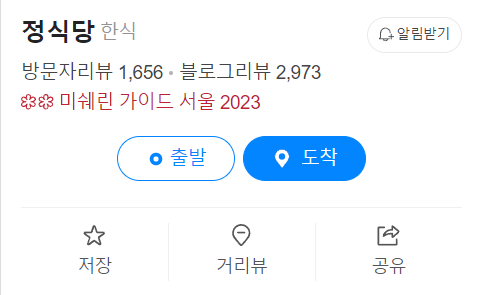

- 정식당의 크롤링 결과 
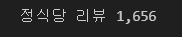

서브웨이 강남역점 

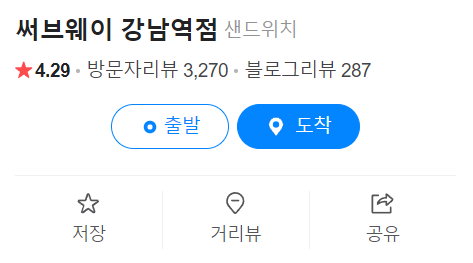

- 서브웨이의 크롤링 결과 
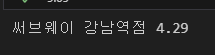

별점 리뷰가 없는데도 있음


-> 이거 어떻게 해야할지 모르겟음

### 수정사항 
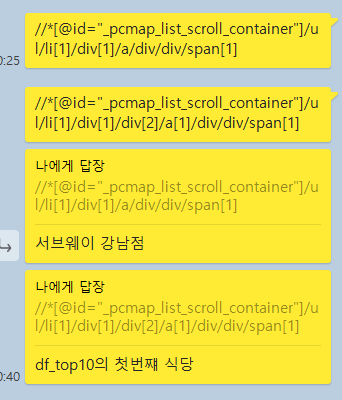

xpath로 했었는데 /ul/li[{} 가 아닌 div[1] 숫자가 바뀔떄도 있어서 {}안의 숫자떄매 안돌아갔었음 

그래서 그냥 class 이름으로 find_element해서 클릭했슴

근데 밑에 except부분은 아직 못찾아서 바꾸지 못함

그리고 사진 클릭하는 부분도 xpath말고 클래스로 찾으니깐 해결됐음

In [12]:
for i in df_top10['사업장명']:
    name = i
    print(name)

정식당
채선당 샤브보트 강남역점
(주)푸들
수아당
오늘은 철판
알찬한끼
마스터즈
세계관
분식을 품다
곰푸드


카테고리 + 이름 없으면 ㄱㄱ 

In [ ]:
for i in df_top10['사업장명']:
    # 검색어를 네이버 url에 포함시켜 이동 + 검색 
    name = i
    driver.get('https://map.naver.com/p/search/{}'.format(name))

    # 저장 
    naver_df = pd.DataFrame()

    time.sleep(3)  

    
    searchIframe = driver.find_element(By.ID,'searchIframe')
    driver.switch_to.frame(searchIframe)
    time.sleep(3) 
# 검색결과 or 식당으로 바로 넘어가는 결과가 나옴 
# ----------------------------------------------------------

    ## 식당이름 + 별점 or 리뷰만 크롤링한다고 했을때 
    ## 바로 넘어가면 Fc1rA이 있고 검색결과만 떴을때는 Fc1rA없음 
    ## 그래서 if문 써서 class이름으로 찾아서 
    if driver.find_elements(By.CLASS_NAME,'Fc1rA') == True :
        restaurant_name = driver.find_element(By.CLASS_NAME,'Fc1rA').text
        review_star = driver.find_element(By.CLASS_NAME,'PXMot').text
        
    else :
        try:
        # {}안에 num 입력 (1번째, 2번째...)
        # 각 카드 상단을 클릭하여 WebDriverWait을 활용 카드 상단 XPATH가 보일때까지 3초 대기 

            driver.find_element(By.CLASS_NAME,'YwYLL').click()
            time.sleep(3) 
            
        except  :
            # 가능하지 않다면 스크롤 내리고 최대 3초까지 기다렸다가 클릭
            # tag 내용이 안 보이면 해당 tag에서 스크롤 내림
            # click()이 안되는 경우 클릭을 대체하여 사용하기 
            driver.find_element(By.TAG_NAME,'body').send_keys(Keys.PAGE_DOWN)
            card_clik = driver.find_element(By.CLASS_NAME,'TTfa9')
            driver.execute_script('arguments[0].click();',card_clik)

        # 기본 프레임
        time.sleep(1)
        driver.switch_to.default_content()
                
        # 오른쪽 프레임
        entryIframe = driver.find_element(By.ID,'entryIframe')
        driver.switch_to.frame(entryIframe)

        # 가게 이름, 변수로 지정
        restaurant_name = driver.find_element(By.CLASS_NAME,'Fc1rA').text

        # 가게 별점이 있는 경우에만 try 
        ## 별점
        try :
            review_star = driver.find_element(By.CLASS_NAME,'PXMot').text
            review_star = review_star[3:]
        except :
            review_star = 0
            pass 
    # 기본 설정으로 돌아오기
    time.sleep(1)
    driver.switch_to.default_content()

    print(restaurant_name,review_star)

In [61]:
for i in df_top10['사업장명']:
    # 검색어를 네이버 url에 포함시켜 이동 + 검색 
    name = i
    driver.get('https://map.naver.com/p/search/{}'.format(name))

    # 저장 
    naver_df = pd.DataFrame()

    time.sleep(3)  

    
    searchIframe = driver.find_element(By.ID,'searchIframe')

    driver.switch_to.frame(searchIframe)
    time.sleep(3) 
# 검색결과 or 식당으로 바로 넘어가는 결과가 나옴 
# ----------------------------------------------------------

    ## 식당이름 + 별점 or 리뷰만 크롤링한다고 했을때 
    ## 바로 넘어가면 Fc1rA이 있고 검색결과만 떴을때는 Fc1rA없음 
    ## 그래서 if문 써서 class이름으로 찾아서 
    if driver.find_elements(By.CLASS_NAME,'Fc1rA') == True :
        restaurant_name = driver.find_element(By.CLASS_NAME,'Fc1rA').text
        review_star = driver.find_element(By.CLASS_NAME,'PXMot').text
        
    else :
        try:
        # {}안에 num 입력 (1번째, 2번째...)
        # 각 카드 상단을 클릭하여 WebDriverWait을 활용 카드 상단 XPATH가 보일때까지 3초 대기 

            driver.find_element(By.CLASS_NAME,'YwYLL').click()
            time.sleep(3) 
            
        except  :
            # 가능하지 않다면 스크롤 내리고 최대 3초까지 기다렸다가 클릭
            # tag 내용이 안 보이면 해당 tag에서 스크롤 내림
            # click()이 안되는 경우 클릭을 대체하여 사용하기 
            driver.find_element(By.TAG_NAME,'body').send_keys(Keys.PAGE_DOWN)
            card_clik = driver.find_element(By.CLASS_NAME,'TTfa9')
            driver.execute_script('arguments[0].click();',card_clik)

        # 기본 프레임
        time.sleep(1)
        driver.switch_to.default_content()
                
        # 오른쪽 프레임
        entryIframe = driver.find_element(By.ID,'entryIframe')
        driver.switch_to.frame(entryIframe)

        # 가게 이름, 변수로 지정
        restaurant_name = driver.find_element(By.CLASS_NAME,'Fc1rA').text

        # 가게 별점이 있는 경우에만 try 
        ## 별점
        try :
            review_star = driver.find_element(By.CLASS_NAME,'PXMot').text
            review_star = review_star[3:]
        except :
            review_star = 0
            pass 
    # 기본 설정으로 돌아오기
    time.sleep(1)
    driver.switch_to.default_content()

    print(restaurant_name,review_star)

정식당 리뷰 1,656
채선당 샤브보트 강남역점 리뷰 56
주주클럽 리뷰 6
수아당 4.68
오늘은쭈꾸미 일산본점 4.48
알찬한끼 0
마스터즈 리뷰 1
세계관 삼성본점 리뷰 37
분식을품다 방배점 리뷰 203
곰푸드 리뷰 182


In [28]:
# place는 매장명, count는 검색했을때 조회하는 범위
def naver_finder(place,count) :

  # 검색어를 네이버 url에 포함시켜 이동 + 검색 
  driver.get('https://map.naver.com/p/search/{}'.format(place))

  # 저장 
  naver_df = pd.DataFrame()
  time.sleep(3)  

  try : 
    # frame을 3갤 나눔 searchIframe(왼쪽), entryIframe(오른쪽),default_content(기본)

    # 왼쪽 프레임
    searchIframe = driver.find_element(By.ID,'searchIframe')
    driver.switch_to.frame(searchIframe)

    ## num이 뭔지 모르겟음 
    ## 그리고 count 조회하는 식당의 수라면 굳이 왜 .
    try : 
      # {}안에 num 입력 (1번째, 2번째...)
      # 각 카드 상단을 클릭하여 WebDriverWait을 활용 카드 상단 XPATH가 보일때까지 3초 대기 
      driver.find_element(By.XPATH,'//*[@id="_pcmap_list_scroll_container"]/ul/li[{}]/div[1]/a'.format(num)).click()


    except :
      # 가능하지 않다면 스크롤 내리고 최대 3초까지 기다렸다가 클릭
      # tag 내용이 안 보이면 해당 tag에서 스크롤 내림
      # click()이 안되는 경우 클릭을 대체하여 사용하기 
      driver.find_element(By.TAG_NAME,'body').send_keys(Keys.PAGE_DOWN)
      card_clik = driver.find_element(By.XPATH,'//*[@id="_pcmap_list_scroll_container"]/ul/li[{}]/div[1]/a'.format(num))
      driver.execute_script('arguments[0].click();',card_clik)

    # 기본 프레임
    time.sleep(1)
    driver.switch_to.default_content()
    
    # 오른쪽 프레임
    entryIframe = driver.find_element(By.ID,'entryIframe')
    driver.switch_to.frame(entryIframe)

    # 가게 이름, 변수로 지정
    restaurant_name = driver.find_element(By.CLASS_NAME,'Fc1rA').text

    # 가게 별점이 있는 경우에만 try 
    try :
      review_star = driver.find_element(By.CLASS_NAME,'PXMot').text
      review_star = re.sub('방문자리뷰',"",review_star)
    except :
      review_star = 0
      pass 

    # 기본 설정으로 돌아오기
    time.sleep(1)
    driver.switch_to.default_content()

    print(restaurant_name,review_star)
    
    # 수정 필요 
    df = pd.DataFrame({'가게명':[restaurant_name],'네이버별점' : [review_star]})
    naver_df = pd.concat([naver_df,df])
    naver_df.drop_duplicates() # 중복 제거 
  except :
    print('정상적으로 작동이 되지 않습니다.')

    return naver_df


In [48]:
for i in df_top10['사업장명']:
    df_sample = naver_finder(i,2)
    time.sleep(5)

정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.
정상적으로 작동이 되지 않습니다.


In [49]:
naver_df

""


In [43]:
df_top10['사업장명']


0              정식당
1    채선당 샤브보트 강남역점
2            (주)푸들
3              수아당
4           오늘은 철판
5             알찬한끼
6             마스터즈
7              세계관
8           분식을 품다
9              곰푸드
Name: 사업장명, dtype: object

In [44]:
len(df)

12535